# Data poisoning attack

In this notebook, we use a convex optimization layer to perform a *data poisoning attack*; i.e., we show how to perturb the data used to train a logistic regression classifier so as to maximally increase the test loss. This example is also presented in section 6.1 of the paper *Differentiable convex optimization layers*.

In [4]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import torch

from cvxpylayers.torch import CvxpyLayer

We are given training data $(x_i, y_i)_{i=1}^{N}$,
where $x_i\in\mathbf{R}^n$ are feature vectors and $y_i\in\{0,1\}$ are the labels.
Suppose we fit a model for this classification problem by solving
\begin{equation}
\begin{array}{ll}
\mbox{minimize} & \frac{1}{N}\sum_{i=1}^N \ell(\theta; x_i, y_i) + r(\theta),
\end{array}
\label{eq:trainlinear}
\end{equation}
where the loss function $\ell(\theta; x_i, y_i)$ is convex in $\theta \in \mathbf{R}^n$ and $r(\theta)$ is a convex
regularizer. We hope that the test loss $\mathcal{L}^{\mathrm{test}}(\theta) =
\frac{1}{M}\sum_{i=1}^M \ell(\theta; \tilde x_i, \tilde y_i)$ is small, where
$(\tilde x_i, \tilde y_i)_{i=1}^{M}$ is our test set. In this  example, we use the logistic loss

\begin{equation}
\ell(\theta; x_i, y_i) = \log(1 + \exp(\beta^Tx_i + b)) - y_i(\beta^Tx_i + b)
\end{equation}

with elastic net regularization

\begin{equation}
r(\theta) = 0.1\|\beta\|_1 + 0.1\|\beta\|_2^2.
\end{equation}

In [5]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

torch.manual_seed(0)
np.random.seed(0)
n = 2
N = 60
X, y = make_blobs(N, n, centers=np.array([[2, 2], [-2, -2]]), cluster_std=3)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.5)

Xtrain, Xtest, ytrain, ytest = map(
    torch.from_numpy, [Xtrain, Xtest, ytrain, ytest])
Xtrain.requires_grad_(True)
m = Xtrain.shape[0]

a = cp.Variable((n, 1))
b = cp.Variable((1, 1))
X = cp.Parameter((m, n))
Y = ytrain.numpy()[:, np.newaxis]

log_likelihood = (1. / m) * cp.sum(
    cp.multiply(Y, X @ a + b) - cp.logistic(X @ a + b)
)
regularization = - 0.1 * cp.norm(a, 1) - 0.1 * cp.sum_squares(a)
prob = cp.Problem(cp.Maximize(log_likelihood + regularization))
fit_logreg = CvxpyLayer(prob, [X], [a, b])

Assume that our training data is subject to a data poisoning attack,
before it is supplied to us. The adversary has full knowledge of our modeling
choice, meaning that they know the form of the optimization problem above, and seeks
to perturb the data to maximally increase our loss on the test
set, to which they also have access. The adversary is permitted to apply an
additive perturbation $\delta_i \in \mathbf{R}^n$ to each of the training points $x_i$,
with the perturbations satisfying $\|\delta_i\|_\infty \leq 0.01$.

Let $\theta^\star$ be optimal.
The gradient of
the test loss with respect to a training data point, $\nabla_{x_i}
\mathcal{L}^{\mathrm{test}}(\theta^\star)$, gives the direction
in which the point should be moved to achieve the greatest
increase in test loss. Hence, one reasonable adversarial policy is to set $x_i
:= x_i +
.01\mathrm{sign}(\nabla_{x_i}\mathcal{L}^{\mathrm{test}}(\theta^\star))$. The
quantity $0.01\sum_{i=1}^N \|\nabla_{x_i}
\mathcal{L}^{\mathrm{test}}(\theta^\star)\|_1$ is the predicted increase in
our test loss due to the poisoning.

In [6]:
from sklearn.linear_model import LogisticRegression

a_tch, b_tch = fit_logreg(Xtrain)
loss = 300 * torch.nn.BCEWithLogitsLoss()((Xtest @ a_tch + b_tch).squeeze(), ytest*1.0)
loss.backward()
Xtrain_grad = Xtrain.grad

Below, we plot the gradient of the test loss with respect to the training data points. The blue and orange points are training data, belonging to different classes. The red line is the hyperplane learned by fitting the the model, while the blue line is the hyperplane that minimizes the test loss. The gradients are visualized as black lines, attached to the data points. Moving the points in the gradient directions torques the learned hyperplane away from the optimal hyperplane for the test set.

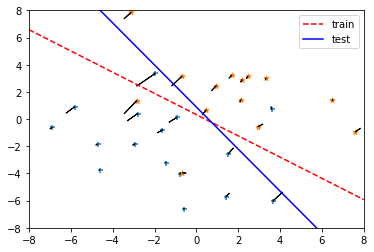

In [17]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(Xtest.numpy(), ytest.numpy())
beta_train = a_tch.detach().numpy().flatten()
beta_test = lr.coef_.flatten()
b_train = b_tch.squeeze().detach().numpy()
b_test = lr.intercept_[0]
hyperplane = lambda x, beta, b: - (b + beta[0] * x) / beta[1]

Xtrain_np = Xtrain.detach().numpy()
Xtrain_grad_np = Xtrain_grad.numpy()
ytrain_np = ytrain.numpy().astype(np.bool)

plt.figure()
plt.scatter(Xtrain_np[ytrain_np, 0], Xtrain_np[ytrain_np, 1], s=25, marker='+')
plt.scatter(Xtrain_np[~ytrain_np, 0], Xtrain_np[~ytrain_np, 1], s=25, marker='*')

for i in range(m):
    plt.arrow(Xtrain_np[i, 0], Xtrain_np[i, 1],
              Xtrain_grad_np[i, 0], Xtrain_grad_np[i, 1])

plt.xlim(-8, 8)
plt.ylim(-8, 8)

plt.plot(np.linspace(-8, 8, 100),
         [hyperplane(x, beta_train, b_train)
          for x in np.linspace(-8, 8, 100)], '--', color='red', label='train')
plt.plot(np.linspace(-8, 8, 100),
         [hyperplane(x, beta_test, b_test)
         for x in np.linspace(-8, 8, 100)], '-', color='blue', label='test')
plt.legend()
plt.savefig("data_poisoning.pdf")
plt.show()